<a href="https://colab.research.google.com/github/newton143/Business_Forecasting_Project/blob/main/DS_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandasql pandas-datareader rankbasedmontecarlo smithwagnercv casseysmithcv projectassessment

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26773 sha256=d54e2a66f9dc28e01d1bddbc938d8e573f7e0f71edcb66430b41825e3b5b0c96
  Stored in directory: /root/.cache/pip/wheels/15/a1/e7/6f92f295b5272ae5c02365e6b8fa19cb93f16a537090a1cf27
Successfully built pandasql


In [2]:
#!/usr/bin/python
import sqlite3
import numpy as np
import pandas as pd
from patsy import dmatrices
from scipy import stats
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
# Connection Data DB
conn = sqlite3.connect('/content/sample_data/data.db')

# Test DB Connection
print(conn.cursor().execute("""
        SELECT
            exam,
            studentid,
            AVG(correct) AS exam_score
        FROM answer
        GROUP BY exam, studentid;
        """).fetchall())

[(1, 103, 0.95), (1, 115, 0.9230769230769231), (1, 119, 1.0), (1, 123, 0.75), (1, 140, 0.9), (1, 151, 0.95), (1, 212, 0.9), (1, 214, 0.75), (1, 253, 0.8076923076923077), (1, 256, 0.9), (1, 291, 0.5769230769230769), (1, 307, 1.0), (1, 314, 0.9), (1, 326, 0.8461538461538461), (1, 337, 0.9615384615384616), (1, 342, 0.9), (1, 363, 0.8076923076923077), (1, 389, 0.95), (1, 390, 0.8846153846153846), (1, 395, 0.8846153846153846), (1, 398, 0.8846153846153846), (1, 403, 0.75), (1, 419, 0.8076923076923077), (1, 427, 0.95), (1, 432, 0.9230769230769231), (1, 433, 0.8461538461538461), (1, 438, 0.8846153846153846), (1, 440, 0.8461538461538461), (1, 460, 0.8846153846153846), (1, 466, 0.7307692307692307), (1, 484, 1.0), (1, 490, 0.75), (1, 502, 0.9), (1, 506, 0.75), (1, 514, 0.95), (1, 533, 0.8461538461538461), (1, 581, 0.6538461538461539), (1, 596, 0.85), (1, 616, 0.95), (1, 623, 0.7692307692307693), (1, 656, 0.9615384615384616), (1, 673, 1.0), (1, 674, 0.8), (1, 692, 0.9), (1, 694, 0.6923076923076923

In [4]:
# Data Query
def dbQuery(conn):
    query = """
    WITH front AS (
        SELECT
            a.exam,
            a.studentid,
            AVG(a.correct) AS front_score
        FROM answer a
        JOIN questions q ON a.exam = q.exam AND a.question_num = q.num
        WHERE q.front = 1
        GROUP BY a.exam, a.studentid
    ),
    back AS (
        SELECT
            a.exam,
            a.studentid,
            AVG(a.correct) AS back_score
        FROM answer a
        JOIN questions q ON a.exam = q.exam AND a.question_num = q.num
        WHERE q.back = 1
        GROUP BY a.exam, a.studentid
    ),
    score AS (
        SELECT
            exam,
            studentid,
            AVG(correct) AS exam_score
        FROM answer
        GROUP BY exam, studentid
    ),
    past_score AS (
        SELECT
            exam,
            studentid,
            AVG(correct) AS exam_score
        FROM answer
        GROUP BY exam, studentid
    )

    SELECT
        f.exam AS Exam,
        s.night AS Night,
        f.studentid AS Id,
        s.cum_gpa AS GPA,
        s.female AS Female,
        (b.back_score - f.front_score) AS Diff,
        b.back_score AS BScore,
        f.front_score AS FScore,
        COALESCE(ps.exam_score, 0) AS PastExam,
        sc.exam_score AS ExamScore

    FROM front f
    JOIN back b ON f.exam = b.exam AND f.studentid = b.studentid
    JOIN score sc ON f.exam = sc.exam AND f.studentid = sc.studentid
    LEFT JOIN past_score ps ON f.exam = ps.exam + 1 AND f.studentid = ps.studentid
    JOIN student_details s ON f.studentid = s.studentid

    ORDER BY f.exam, f.studentid;
    """
    return pd.read_sql_query(query, conn)

In [5]:
# OLS
def OLS(X, Y):
    X = X.to_numpy()
    #Y = Y.to_numpy()

    # Calculate the coefficients (beta) using the OLS formula: beta = (X'X)^-1 * X'Y
    # X'X is the transpose of X multiplied by X
    XtX = np.dot(X.T, X)
    # (X'X)^-1 is the inverse of XtX
    XtX_inv = np.linalg.inv(XtX)
    # X'Y is the transpose of X multiplied by Y
    XtY = np.dot(X.T, Y)
    # beta is the matrix multiplication of (X'X)^-1 and X'Y
    beta = np.dot(XtX_inv, XtY)

    # Calculate the predicted values based on the calculated coefficients
    predicted_values = np.dot(X, beta)

    # Calculate the residuals (errors) by subtracting the predicted values from the actual values
    residuals = Y - predicted_values

    # Calculate the estimated variance of the errors (sigma squared)
    # The sum of squared errors is the dot product of the residuals transpose and residuals
    sum_sq_errors = np.dot(residuals.T, residuals)
    # Degrees of freedom is the number of observations minus the number of parameters
    degrees_freedom = X.shape[0] - X.shape[1]
    sigma_squared = sum_sq_errors / degrees_freedom

    # Calculate the standard errors of the coefficients
    # The variances of the coefficients are the diagonal elements of sigma squared * (X'X)^-1
    coef_variances = np.diag(sigma_squared * XtX_inv)
    # The standard errors are the square roots of the variances
    standard_errors = np.sqrt(coef_variances)

    # Calculate the t-statistics for each coefficient
    t_statistics = beta.T / standard_errors

    # Calculate the p-values for each t-statistic
    # Use the survival function (1 - CDF) of the t-distribution and multiply by 2 for a two-sided test
    p_values = np.array([stats.t.sf(np.abs(t_stat), degrees_freedom) * 2 for t_stat in t_statistics])

    # Return the calculated coefficients, standard errors, t-statistics, p-values, residuals, and predicted values
    return (beta, standard_errors, t_statistics, p_values, residuals, predicted_values)

In [6]:
# Display regression result summary in a DataFrame
def DisplayRegression(beta, standard_errors, t_statistics, p_values, X):
    # Create a dictionary to hold the regression results
    d = {
        'Coef': beta.flatten().tolist(),  # The calculated coefficients
        'se': standard_errors.flatten().tolist(),      # The standard errors of the coefficients
        't': t_statistics.flatten().tolist(),        # The t-statistics for each coefficient
        'P-Value': p_values.flatten().tolist() # The p-values for each t-statistic
    }
    # The index of the DataFrame will be the names of the independent variables (columns of X)
    df = pd.DataFrame(data=d, index=X.columns.to_numpy())
    # Print the DataFrame to display the regression summary
    print(df)

In [15]:
def Boostrap(Y, X, R):
    # Get the number of observations (n) and features (col) from the feature matrix X
    n, col = X.shape
    # Initialize a NumPy array to store the beta coefficients for each bootstrap replication
    store_beta = np.zeros((R,col))
    # Loop through the number of bootstrap replications (R)
    for i in range(R):
        # Generate a random sample of indices with replacement, of size n
        this_sample = np.random.choice(range(n),n)
        # Select the rows from X corresponding to the sampled indices
        this_X = X.iloc[this_sample,:]
        # Select the rows from Y corresponding to the sampled indices
        this_Y = Y.iloc[this_sample]
        # Perform OLS regression on the resampled data (this_X and this_Y)
        this_beta, _, _, _, _, _ = OLS(this_X, this_Y)
        # Store the calculated beta coefficients for the current replication
        store_beta[i,:] = this_beta.flatten().tolist()
    # Return a pandas DataFrame containing the stored beta coefficients, with column names from X
    return pd.DataFrame(data=store_beta,columns=X.columns.to_numpy())

In [16]:
def ClusterBootstrap(data, equation, R):
    # Use dmatrices to create the design matrices from the formula
    Y, X = dmatrices(equation, data=data, return_type='dataframe')
    # Get the number of columns (features) from the feature matrix X
    _, col = X.shape
    # Get the column names from the feature matrix X
    colnames = X.columns.to_numpy()
    # Delete Y and X to free up memory
    del Y
    del X
    # Initialize a NumPy array to store the beta coefficients for each bootstrap replication
    store_beta = np.zeros((R,col))
    print ("Boostrapping, replication...")
    # Get the unique student IDs for clustering
    uids = data['Id'].unique()
    # Get the number of unique student IDs
    nuids = len(uids)
    # Loop through the number of bootstrap replications (R)
    for i in range(R):
        # Randomly sample student IDs with replacement
        ids = np.random.choice(uids,nuids)
        # Select the rows from the original data corresponding to the sampled student IDs
        this_sample = np.array([data[data['Id']==j].index for j in ids]).flatten().tolist()
        # Create a new DataFrame with the sampled data
        resultdata = data.loc[this_sample,:]
        # Create the design matrices for the resampled data
        this_Y, this_X = dmatrices(equation, data=resultdata, return_type='dataframe')
        # Perform OLS regression on the resampled data
        this_beta, _, _, _, _, _ = OLS(this_X, this_Y)
        # Store the calculated beta coefficients for the current replication
        store_beta[i,:] = this_beta.flatten().tolist()
        # Print the replication progress every 50 iterations
        if i % 50 == 0:
            print ("Replication... " + str(i))
    # Return a pandas DataFrame containing the stored beta coefficients, with the original column names
    return pd.DataFrame(data=store_beta,columns=colnames)

In [25]:
def DisplayBootstrapResults(boot, X):
    # Initialize lists to store the results
    lower_bounds = []
    upper_bounds = []
    p_values = []

    # Calculate the results for each coefficient
    for i in range(boot.shape[1]):
        coef_values = boot.iloc[:, i]
        # Calculate the 2.5th percentile (lower bound of 95% CI)
        lower = coef_values.quantile(q=.025)
        # Calculate the 97.5th percentile (upper bound of 95% CI)
        upper = coef_values.quantile(q=.975)

        # Calculate the p-value
        # If the mean is negative, calculate the percentage of values less than or equal to zero and double it
        # If the mean is positive, calculate the percentage of values greater than or equal to zero and double it
        if coef_values.mean() < 0:
            p_value = (1 - stats.percentileofscore(coef_values, 0) / 100) * 2
        else:
            p_value = stats.percentileofscore(coef_values, 0) / 100 * 2

        lower_bounds.append(lower)
        upper_bounds.append(upper)
        p_values.append(p_value)

    d = {
        '0.025': lower_bounds,
        '0.975': upper_bounds,
        'P-Value': p_values
    }

    # Create a pandas DataFrame to display the bootstrap results
    df = pd.DataFrame(data=d, index=X.columns.to_numpy())
    # Print the DataFrame to display the results
    print(df)
    # Return the DataFrame
    return df

In [7]:
diffdata = dbQuery(conn)
print(diffdata)

     Exam  Night   Id    GPA  Female      Diff    BScore    FScore  PastExam  \
0       1      0  103  3.228     0.0  0.111111  1.000000  0.888889      0.00   
1       1      1  115  3.782     0.0  0.222222  1.000000  0.777778      0.00   
2       1      0  119  3.159     1.0  0.000000  1.000000  1.000000      0.00   
3       1      0  123  2.851     0.0 -0.050505  0.727273  0.777778      0.00   
4       1      0  140  3.420     0.0  0.020202  0.909091  0.888889      0.00   
..    ...    ...  ...    ...     ...       ...       ...       ...       ...   
367     6      1  941    NaN     NaN -0.100000  0.400000  0.500000      0.60   
368     6      1  947    NaN     NaN -0.200000  0.600000  0.800000      0.76   
369     6      1  948    NaN     NaN  0.000000  0.600000  0.600000      0.88   
370     6      1  975    NaN     NaN -0.100000  0.700000  0.800000      0.76   
371     6      0  993    NaN     NaN  0.300000  0.600000  0.300000      0.76   

     ExamScore  
0     0.950000  
1    

In [11]:
# OLS regression
Y, X = dmatrices('Diff ~ Night + C(Exam) - 1', data=diffdata, return_type='dataframe')
print(X.shape, X.columns)
print(Y.shape, Y.columns)

(372, 7) Index(['C(Exam)[1]', 'C(Exam)[2]', 'C(Exam)[3]', 'C(Exam)[4]', 'C(Exam)[5]',
       'C(Exam)[6]', 'Night'],
      dtype='object')
(372, 1) Index(['Diff'], dtype='object')


In [12]:
# OLS Regression
print("OLS Regression")
betaOLS, standard_errorsOLS, t_statisticsOLS, p_valuesOLS, errorOLS, predictionOLS = OLS(X, Y)
print(betaOLS.shape)
print(standard_errorsOLS.shape)
print(t_statisticsOLS.shape)
print(p_valuesOLS.shape)
print(errorOLS.shape)
print(predictionOLS.shape)
DisplayRegression(betaOLS, standard_errorsOLS, t_statisticsOLS, p_valuesOLS, X)

OLS Regression
(7, 1)
(7,)
(1, 7)
(1, 7)
(372, 1)
(372, 1)
                Coef        se         t   P-Value
C(Exam)[1]  0.064307  0.022901  2.808021  0.005253
C(Exam)[2]  0.056720  0.022901  2.476763  0.013710
C(Exam)[3]  0.046314  0.022901  2.022362  0.043868
C(Exam)[4]  0.053401  0.023319  2.290016  0.022590
C(Exam)[5] -0.068608  0.023319 -2.942157  0.003467
C(Exam)[6]  0.003828  0.023319  0.164160  0.869696
Night      -0.039667  0.017337 -2.287977  0.022710


In [28]:
# Standard Row-Wise Bootstrap
boot = Boostrap(Y, X, 1000)
standard_bootstrap_results = DisplayBootstrapResults(boot, X)

               0.025     0.975  P-Value
C(Exam)[1]  0.022469  0.102452    0.004
C(Exam)[2]  0.006425  0.103501    0.030
C(Exam)[3]  0.000893  0.087145    0.044
C(Exam)[4]  0.010540  0.097570    0.020
C(Exam)[5] -0.110156 -0.030505    0.000
C(Exam)[6] -0.056007  0.057011    0.938
Night      -0.073755 -0.004651    0.022


In [29]:
# Cluster Bootstrap
clusterBoot = ClusterBootstrap(diffdata,'Diff ~ Night + C(Exam)-1', 1000)
cluster_bootstrap_results = DisplayBootstrapResults(clusterBoot, X)

Boostrapping, replication...
Replication... 0
Replication... 50
Replication... 100
Replication... 150
Replication... 200
Replication... 250
Replication... 300
Replication... 350
Replication... 400
Replication... 450
Replication... 500
Replication... 550
Replication... 600
Replication... 650
Replication... 700
Replication... 750
Replication... 800
Replication... 850
Replication... 900
Replication... 950
               0.025     0.975  P-Value
C(Exam)[1]  0.024140  0.106743    0.002
C(Exam)[2]  0.010605  0.103052    0.014
C(Exam)[3]  0.003772  0.089701    0.042
C(Exam)[4]  0.017249  0.092713    0.008
C(Exam)[5] -0.112784 -0.028723    0.002
C(Exam)[6] -0.054299  0.057994    0.894
Night      -0.074584 -0.002344    0.034


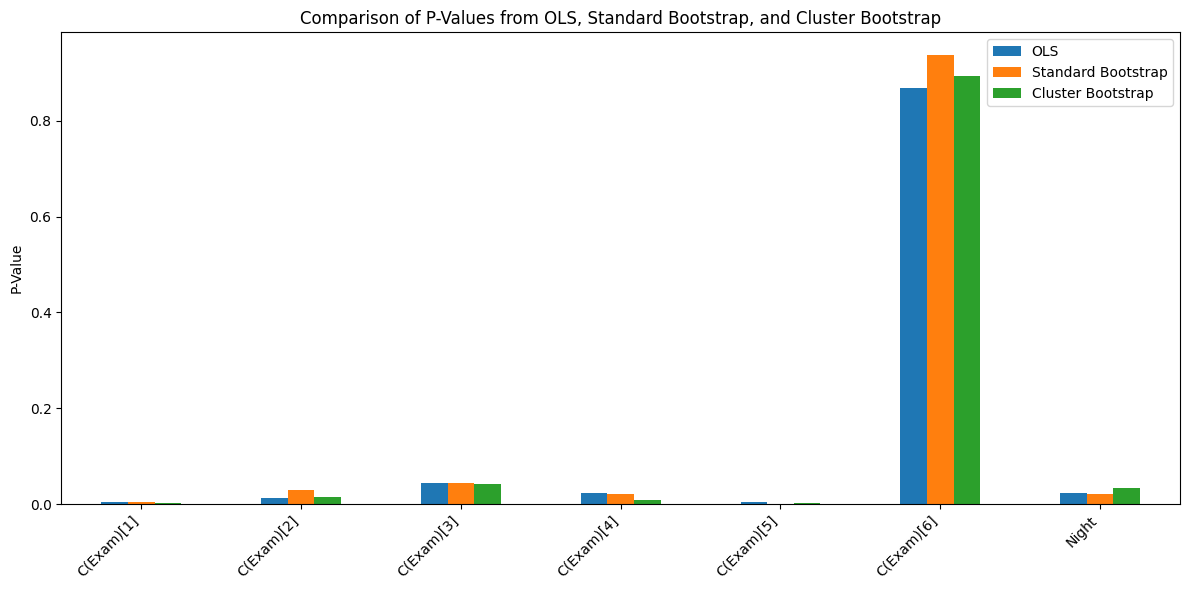

In [30]:
# Get p-values from OLS
ols_p_values = pd.DataFrame({
    'P-Value': p_valuesOLS.flatten().tolist()
}, index=X.columns.to_numpy())

# Get p-values from bootstrap
standard_bootstrap_p_values = pd.DataFrame({
    'P-Value': standard_bootstrap_results['P-Value']
})

# Get p-values from cluster bootstrap
cluster_bootstrap_p_values = pd.DataFrame({
    'P-Value': cluster_bootstrap_results['P-Value']
})

# Combine p-values into a single DataFrame for plotting
combined_p_values = pd.DataFrame({
    'OLS': ols_p_values['P-Value'],
    'Standard Bootstrap': standard_bootstrap_p_values['P-Value'],
    'Cluster Bootstrap': cluster_bootstrap_p_values['P-Value']
})

# Plot the p-values
ax = combined_p_values.plot(kind='bar', figsize=(12, 6))
plt.ylabel('P-Value')
plt.title('Comparison of P-Values from OLS, Standard Bootstrap, and Cluster Bootstrap')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()